## FYS-STK4155 
## Project 2

### Configure Notebook


In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV

from mylearn.linear_model import LinearRegression, RidgeRegression, GDRegressor
#from mylearn.neural_network import NeuralNetwork
from mylearn.ml_tools import *
from mylearn.project_tools import fig_path
from sklearn.linear_model import SGDRegressor
import seaborn as sns

from imageio import imread
from numpy.random import normal, uniform

# Set fontsizes in figures
params = {'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
plt.rc('text', usetex=False)

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SGD for Scikit-Learn

Inversion: 2.277810398751483 [2.2778104  2.69663456]
Batch GD: 1.8018808898671517 [2.57238999 2.84711198]
Stochastic GD: 1.3090268549565651 [3.17540341 2.78992922]
Mini-Batch GD: 1.825656831228176 [2.63464391 2.90169549]
SGDreg from Sklearn: [2.2903348] [2.2903348  2.66038725]


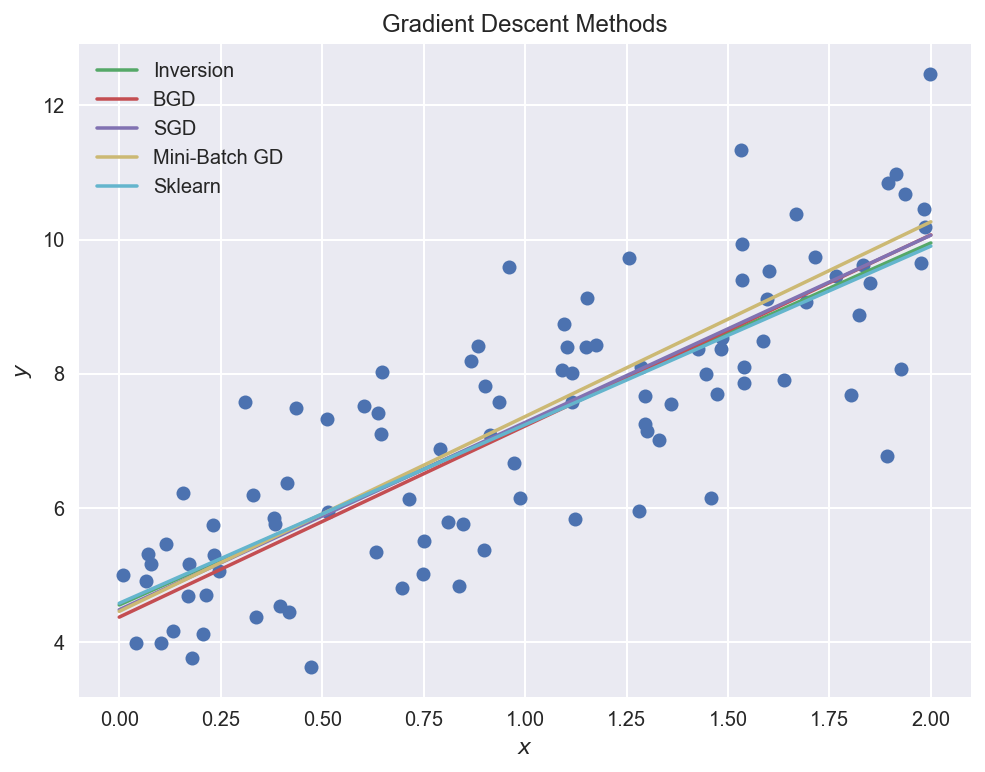

In [158]:
m = 100

# Training data
x = 2 * np.random.rand(m, 1)
y = 4 + 3 * x + np.random.randn(m, 1)
X = np.c_[np.ones((m, 1)), x]

# Test data
xnew = np.array([[0], [2]])
Xnew = np.c_[np.ones((2, 1)), xnew]

# Matrix inversion
inv_reg = GDRegressor(gamma=0, lmbda=0, eta=0.01, n_epochs=100, t0=5, t1=50, batch_size=20, fit_intercept=True)
inv_reg.fit(X, y.ravel(), method="Inv")
ypred_inv = inv_reg.predict(Xnew)
print("Inversion:", inv_reg.intercept_, inv_reg.coef_)

# Batch GD
bgd_reg = GDRegressor(gamma=0, lmbda=0, eta=0.01, n_epochs=100, t0=5, t1=50, batch_size=20, fit_intercept=True)
bgd_reg.fit(X, y.ravel(), method="BGD")
ypred_bgd = bgd_reg.predict(Xnew)
print("Batch GD:", bgd_reg.intercept_, bgd_reg.coef_)

# Stochastic GD
sgd_reg = GDRegressor(gamma=0, lmbda=0, eta=0.01, n_epochs=100, t0=5, t1=50, batch_size=20, fit_intercept=True)
sgd_reg.fit(X, y.ravel(), method="SGD")
ypred_sgd = sgd_reg.predict(Xnew)
print("Stochastic GD:", sgd_reg.intercept_, sgd_reg.coef_)

# Mini-Batch GD
mbgd_reg = GDRegressor(gamma=0, lmbda=0, eta=0.01, n_epochs=100, t0=5, t1=50, batch_size=20, fit_intercept=True)
mbgd_reg.fit(X, y.ravel(), method="MBGD")
ypred_mbgd = mbgd_reg.predict(Xnew)
print("Mini-Batch GD:", mbgd_reg.intercept_, mbgd_reg.coef_)

# SGDRegressor Sklearn
sgdreg_sk = SGDRegressor(max_iter=100, penalty=None, eta0=0.01, alpha=0)
sgdreg_sk.fit(X, y.ravel())
print("SGDreg from Sklearn:", sgdreg_sk.intercept_, sgdreg_sk.coef_)
ypred_sk = sgdreg_sk.predict(Xnew)


fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn')
plt.plot(x, y, "o")
plt.plot(xnew, ypred_inv, "-", label="Inversion")
plt.plot(xnew, ypred_bgd, "-", label="BGD")
plt.plot(xnew, ypred_sgd, "-", label="SGD")
plt.plot(xnew, ypred_mbgd, "-", label="Mini-Batch GD")
plt.plot(xnew, ypred_sk, "-", label="Sklearn")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title("Gradient Descent Methods")
plt.legend()
plt.show()
fig.savefig(fig_path("Algorithms.pdf"), dpi=300)


# Plot of MSE OLS against learning rates with CV



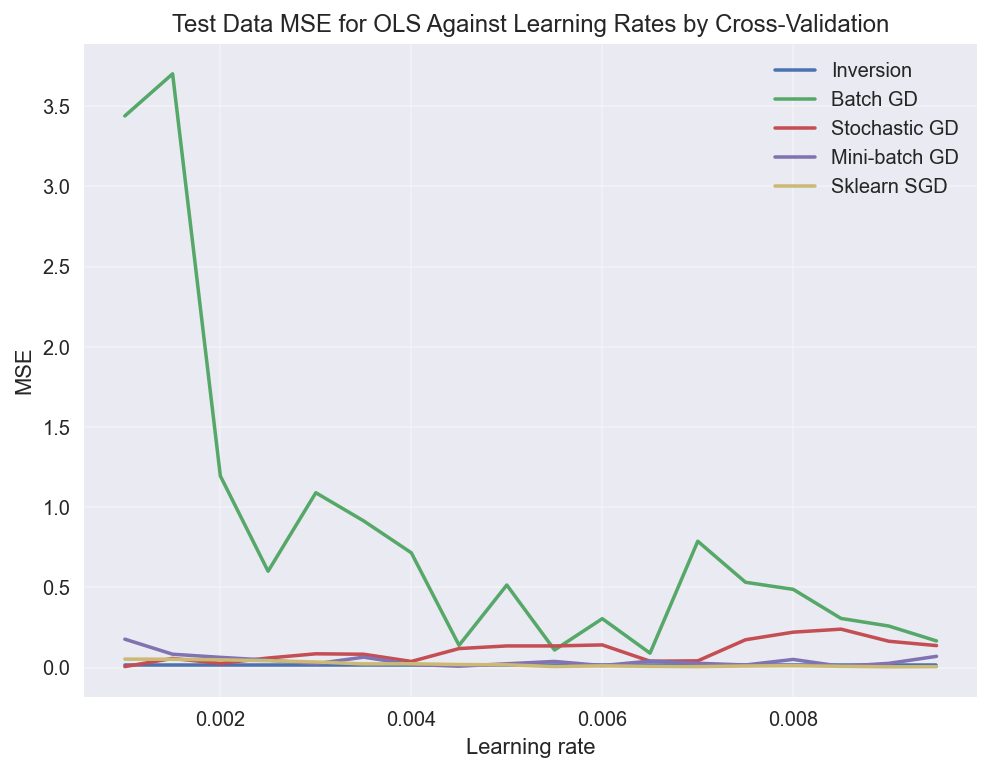

In [172]:
from sklearn.model_selection import KFold

# PLOT OF OLS REGRESSION AS FUNCTION OF THE CHOSEN LEARNING RATES

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_lr = 0.01
step = 0.0005
lrs = np.arange(0.001, max_lr, step, dtype=float)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

scores_KFold_inv = np.zeros((len(lrs), k))
scores_KFold_bgd = np.zeros((len(lrs), k))
scores_KFold_sgd = np.zeros((len(lrs), k))
scores_KFold_mbgd = np.zeros((len(lrs), k))
scores_KFold_sgd_sklearn = np.zeros((len(lrs), k))

deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, lr in enumerate(lrs):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        inv_reg = GDRegressor(eta=lr, fit_intercept=True)
        bgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        sgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        mbgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        sgdreg_sk = SGDRegressor(max_iter=1000, penalty=None, eta0=lr, alpha=0, 
                                 tol=1e-5, fit_intercept=True) # sklearn
        
        inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")
        
        sgdreg_sk.fit(X_train_scaled, z_train_scaled) #sklearn
        z_pred_sk = sgdreg_sk.predict(X_test_scaled)
        
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd_sklearn[i, j] = mean_squared_error(z_test_scaled, z_pred_sk)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)
mse_KFold_sgd_sklearn = np.mean(scores_KFold_sgd_sklearn, axis=1)

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
plt.plot(lrs, mse_KFold_inv, label='Inversion')
plt.plot(lrs, mse_KFold_bgd, label='Batch GD')
plt.plot(lrs, mse_KFold_sgd, label='Stochastic GD')
plt.plot(lrs, mse_KFold_mbgd, label='Mini-batch GD')
plt.plot(lrs, mse_KFold_sgd_sklearn, label='Sklearn SGD')
plt.legend()
plt.xlabel("Learning rate")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE for OLS Against Learning Rates by Cross-Validation')
plt.show()
fig.savefig(fig_path("OLS_MSE_lrs_momentum_epochs_75.pdf"), dpi=300)

# Ridge MSE against learning rates with CV



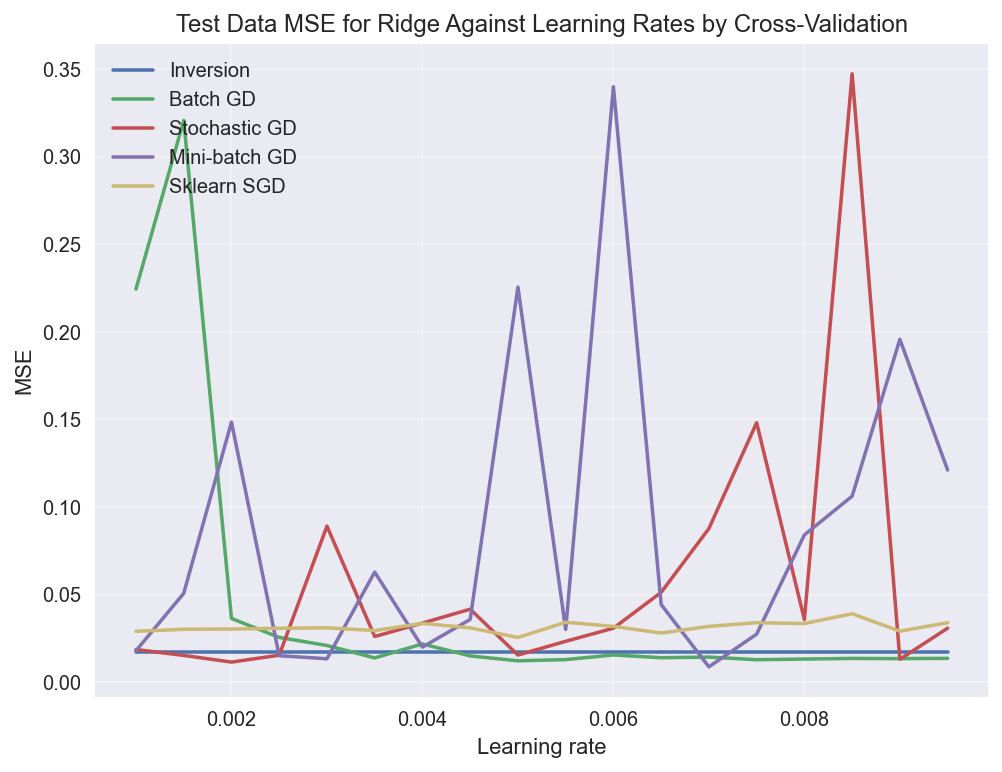

In [177]:
from sklearn.model_selection import KFold

# PLOT OF RIDGE (LAMBDA=1) REGRESSION AS FUNCTION OF THE CHOSEN LEARNING RATES

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_lr = 0.01
step = 0.0005
lrs = np.arange(0.001, max_lr, step, dtype=float)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE

scores_KFold_inv = np.zeros((len(lrs), k))
scores_KFold_bgd = np.zeros((len(lrs), k))
scores_KFold_sgd = np.zeros((len(lrs), k))
scores_KFold_mbgd = np.zeros((len(lrs), k))
scores_KFold_sgd_sklearn = np.zeros((len(lrs), k))

deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, lr in enumerate(lrs):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        inv_reg = GDRegressor(lmbda=1, eta=lr, t0=5, t1=50, gamma=0, 
                              n_epochs=250, batch_size=20, tol=1e-5, fit_intercept=True)
    
        bgd_reg = GDRegressor(lmbda=1, eta=lr, t0=5, t1=50, gamma=0, 
                              n_epochs=250, batch_size=20, tol=1e-5, fit_intercept=True)
        sgd_reg = GDRegressor(lmbda=1, eta=lr, t0=5, t1=50, gamma=0.9, 
                              n_epochs=250, batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=1, eta=lr, t0=5, t1=50, gamma=0.9, 
                              n_epochs=250, batch_size=20, tol=1e-5, fit_intercept=True)
        sgdreg_sk = SGDRegressor(max_iter=1000, penalty="l2", eta0=lr, alpha=1, 
                                 tol=1e-5, fit_intercept=True) # sklearn
        
        inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")
        
        sgdreg_sk.fit(X_train_scaled, z_train_scaled) #sklearn
        z_pred_sk = sgdreg_sk.predict(X_test_scaled)

        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd_sklearn[i, j] = mean_squared_error(z_test_scaled, z_pred_sk)
        
    j += 1


mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)
mse_KFold_sgd_sklearn = np.mean(scores_KFold_sgd_sklearn, axis=1)

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
plt.plot(lrs, mse_KFold_inv, label='Inversion')
plt.plot(lrs, mse_KFold_bgd, label='Batch GD')
plt.plot(lrs, mse_KFold_sgd, label='Stochastic GD')
plt.plot(lrs, mse_KFold_mbgd, label='Mini-batch GD')
plt.plot(lrs, mse_KFold_sgd_sklearn, label='Sklearn SGD')
plt.legend(loc="upper left")
plt.xlabel("Learning rate")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE for Ridge Against Learning Rates by Cross-Validation')
plt.show()
fig.savefig(fig_path("Ridge_MSE_lrs_momentum_250_epochs.pdf"), dpi=300)

# Plot of MSE Ridge against hyperparameter lambda with CV



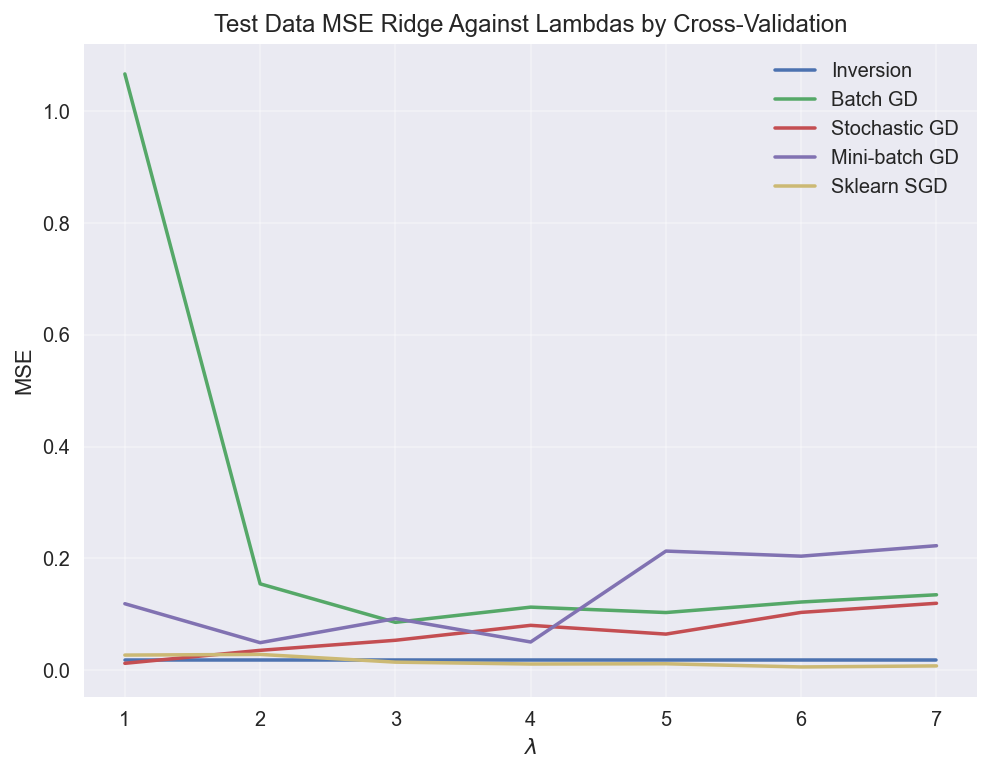

In [132]:
from sklearn.model_selection import KFold

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_lmbda = 8
step = 1
lmbdas = np.arange(1, max_lmbda, step, dtype=float)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

scores_KFold_inv = np.zeros((len(lmbdas), k))
scores_KFold_bgd = np.zeros((len(lmbdas), k))
scores_KFold_sgd = np.zeros((len(lmbdas), k))
scores_KFold_mbgd = np.zeros((len(lmbdas), k))
scores_KFold_sgd_sklearn = np.zeros((len(lmbdas), k))

deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, lmb in enumerate(lmbdas):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        inv_reg = GDRegressor(lmbda=lmb, eta=0.01, t0=5, t1=50, gamma=0, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
    
        bgd_reg = GDRegressor(lmbda=lmb, eta=0.01, t0=5, t1=50, gamma=0, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        sgd_reg = GDRegressor(lmbda=lmb, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=lmb, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        sgdreg_sk = SGDRegressor(max_iter=1000, penalty="l2", eta0=0.01, alpha=lmb, 
                                 tol=1e-5, fit_intercept=True) # sklearn
        
        inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")
        sgdreg_sk.fit(X_train_scaled, z_train_scaled) #sklearn
        z_pred_sk = sgdreg_sk.predict(X_test_scaled)
       
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd_sklearn[i, j] = mean_squared_error(z_test_scaled, z_pred_sk)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)
mse_KFold_sgd_sklearn = np.mean(scores_KFold_sgd_sklearn, axis=1)

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
plt.plot(lmbdas, mse_KFold_inv, label='Inversion')
plt.plot(lmbdas, mse_KFold_bgd, label='Batch GD')
plt.plot(lmbdas, mse_KFold_sgd, label='Stochastic GD')
plt.plot(lmbdas, mse_KFold_mbgd, label='Mini-batch GD')
plt.plot(lmbdas, mse_KFold_sgd_sklearn, label='Sklearn SGD')
plt.legend()
plt.xlabel(r"$\lambda$")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE Ridge Against Lambdas by Cross-Validation')
plt.show()
fig.savefig(fig_path("Ridge_MSE_lmbdas_momentum_100_epochs.pdf"), dpi=300)

# Plot of MSE against mini batch sizes for OLS

Below is the plot generated for MSE against various mini batch sizes for mini-batch gradient descent for OLS with CV. The number of mini batches is given by 

Number of minibatches: $b = \frac{m}{\text{batch_size}}$  


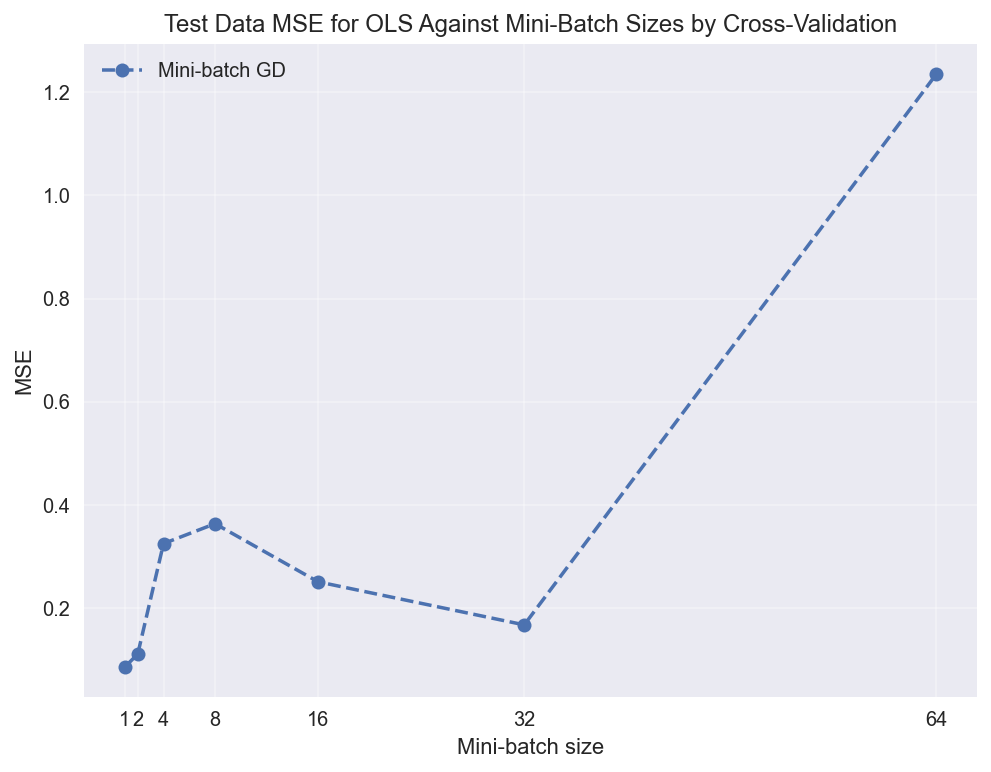

In [165]:
from sklearn.model_selection import KFold

# PLOT OF OLS REGRESSION AS FUNCTION OF THE CHOSEN mini batch sizes

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_b_size = 50
step = 1
#b_sizes = np.arange(1, max_b_size, step, dtype=float)
b_sizes = [2**i for i in range(7)]

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

#scores_KFold_inv = np.zeros((len(lrs), k))
#scores_KFold_bgd = np.zeros((len(lrs), k))
#scores_KFold_sgd = np.zeros((len(lrs), k))
scores_KFold_mbgd = np.zeros((len(b_sizes), k))


deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, bs in enumerate(b_sizes):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        #inv_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
    
        #bgd_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
        #sgd_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0.9, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=0, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=250, batch_size=bs, tol=1e-5, fit_intercept=True)
        
        
        #inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        #bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        #sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")        
       
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

#mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
#mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
#mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)

#m = 100
#mini_batches = m/b_sizes
#print(type(mini_batches))

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
#plt.plot(lrs, mse_KFold_inv, label='Inversion')
#plt.plot(lrs, mse_KFold_bgd, label='Batch GD')
#plt.plot(lrs, mse_KFold_sgd, label='Stochastic GD')
plt.plot(b_sizes, mse_KFold_mbgd, 'o--', label='Mini-batch GD')
plt.xticks(b_sizes)
plt.legend()
plt.xlabel("Mini-batch size")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE for OLS Against Mini-Batch Sizes by Cross-Validation')
plt.show()
fig.savefig(fig_path("OLS_MSE_mini_b_momentum.pdf"), dpi=300)

# Plot of MSE Ridge against mini batch sizes with CV

Below is the plot generated for MSE against various mini batch sizes for mini-batch gradient descent for OLS with CV. The number of mini batches is given by 

Number of minibatches: $b = \frac{m}{\text{batch_size}}$  


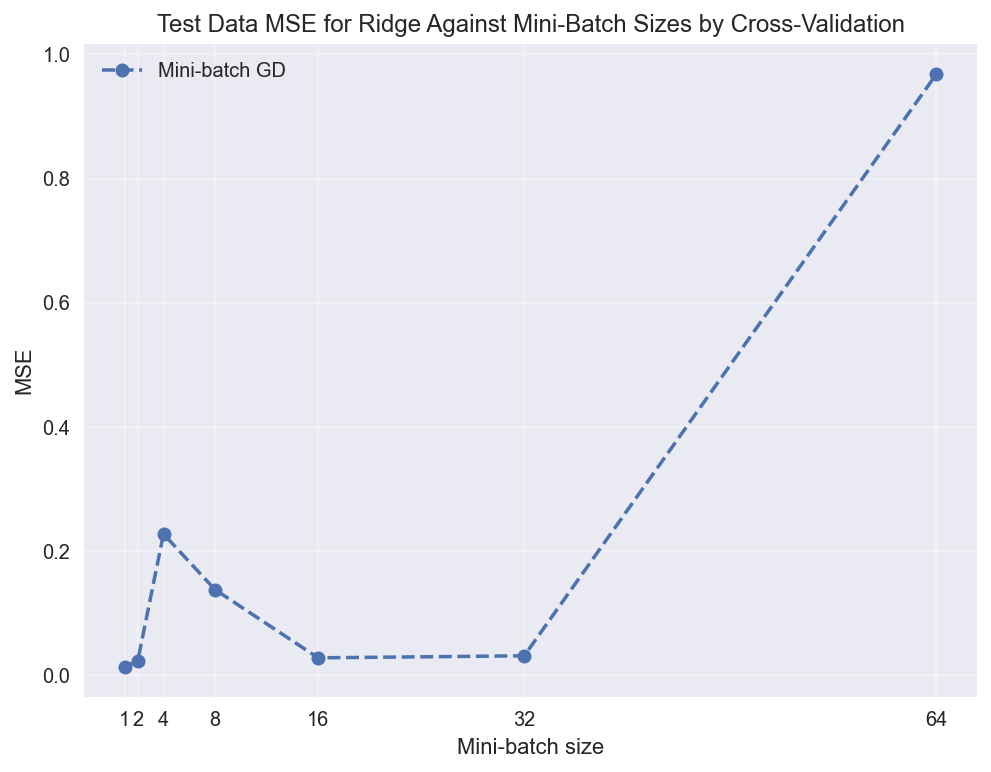

In [164]:
from sklearn.model_selection import KFold

# PLOT OF RIDGE REGRESSION AS FUNCTION OF THE CHOSEN mini batch sizes

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_b_size = 50
step = 1
#b_sizes = np.arange(1, max_b_size, step, dtype=float)
b_sizes = [2**i for i in range(7)]

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

#scores_KFold_inv = np.zeros((len(lrs), k))
#scores_KFold_bgd = np.zeros((len(lrs), k))
#scores_KFold_sgd = np.zeros((len(lrs), k))
scores_KFold_mbgd = np.zeros((len(b_sizes), k))


deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, bs in enumerate(b_sizes):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        #inv_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
    
        #bgd_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
        #sgd_reg = GDRegressor(lmbda=0, eta=lr, n_iter=1000, t0=5, t1=50, gamma=0.9, 
                              #n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=1, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=250, batch_size=bs, tol=1e-5, fit_intercept=True)
        
        
        #inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        #bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        #sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")        
       
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        #scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

#mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
#mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
#mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)

#m = 100
#mini_batches = m/b_sizes
#print(type(mini_batches))

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
#plt.plot(lrs, mse_KFold_inv, label='Inversion')
#plt.plot(lrs, mse_KFold_bgd, label='Batch GD')
#plt.plot(lrs, mse_KFold_sgd, label='Stochastic GD')
plt.plot(b_sizes, mse_KFold_mbgd, 'o--', label='Mini-batch GD')
plt.xticks(b_sizes)
plt.legend()
plt.xlabel("Mini-batch size")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE for Ridge Against Mini-Batch Sizes by Cross-Validation')
plt.show()
fig.savefig(fig_path("Ridge_MSE_mini_b_momentum.pdf"), dpi=300)

# Plot of MSE OLS versus model complexity 

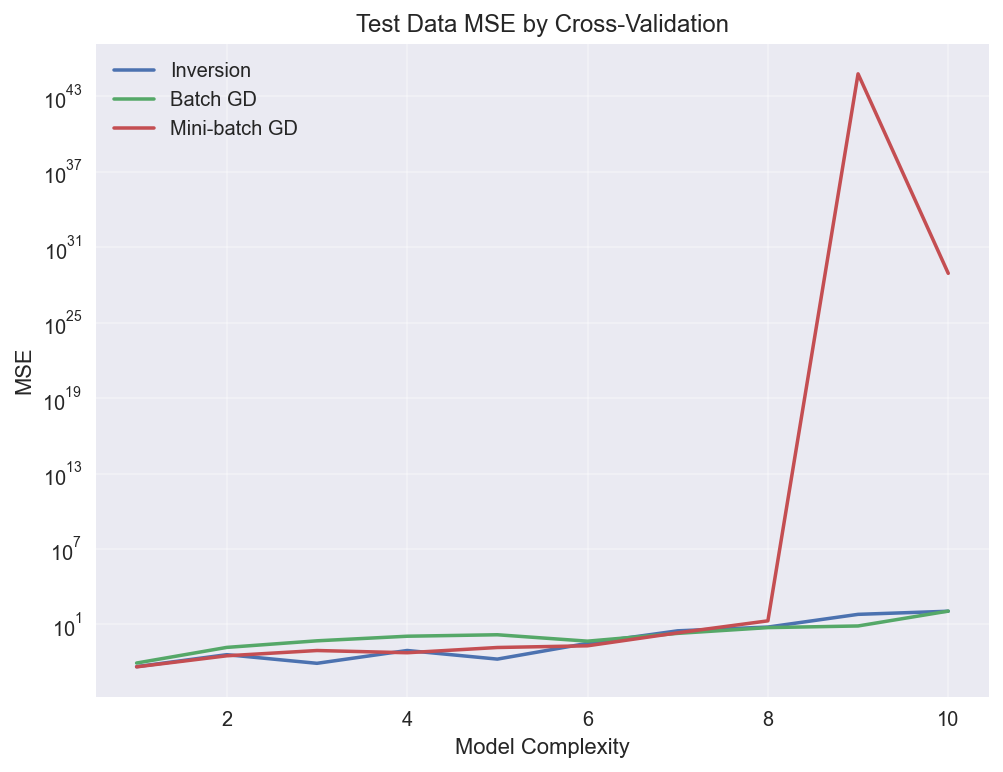

In [166]:
from sklearn.model_selection import KFold

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
maxdeg = 10
degrees = np.arange(1, maxdeg+1, dtype=int)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

scores_KFold_inv = np.zeros((maxdeg, k))
scores_KFold_bgd = np.zeros((maxdeg, k))
scores_KFold_sgd = np.zeros((maxdeg, k))
scores_KFold_mbgd = np.zeros((maxdeg, k))

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        inv_reg = GDRegressor(lmbda=0, eta=0.01, t0=5, t1=50, gamma=0, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        bgd_reg = GDRegressor(lmbda=0, eta=0.01, t0=5, t1=50, gamma=0, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        sgd_reg = GDRegressor(lmbda=0, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=0, eta=0.01, t0=5, t1=50, gamma=0.9, 
                              n_epochs=100, batch_size=20, tol=1e-5, fit_intercept=True)

        
        inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")
        
        
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)

fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn')
plt.grid(alpha=0.3)
plt.plot(degrees, mse_KFold_inv, label='Inversion')
plt.plot(degrees, mse_KFold_bgd, label='Batch GD')
#plt.plot(degrees, mse_KFold_sgd, label='Stochastic GD')
plt.plot(degrees, mse_KFold_mbgd, label='Mini-batch GD')
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.yscale('log')
plt.title('Test Data MSE by Cross-Validation')
plt.show()

# Plot of MSE Ridge against model complexity

In [ ]:
from sklearn.model_selection import KFold

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
maxdeg = 10
degrees = np.arange(1, maxdeg+1, dtype=int)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
#scores_KFold_train = np.zeros((maxdeg, k))
#scores_KFold_test = np.zeros((maxdeg, k))

scores_KFold_inv = np.zeros((maxdeg, k))
scores_KFold_bgd = np.zeros((maxdeg, k))
scores_KFold_sgd = np.zeros((maxdeg, k))
scores_KFold_mbgd = np.zeros((maxdeg, k))

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)
    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        '''
        def __init__(self, lmbda=0, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                 n_epochs=50, batch_size=20, tol=1e-5, fit_intercept=True):
        '''
        
        inv_reg = GDRegressor(lmbda=1, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                              batch_size=20, tol=1e-5, fit_intercept=True)
        bgd_reg = GDRegressor(lmbda=1, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0, 
                              batch_size=20, tol=1e-5, fit_intercept=True)
        sgd_reg = GDRegressor(lmbda=1, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0.9,
                              batch_size=20, tol=1e-5, fit_intercept=True)
        mbgd_reg = GDRegressor(lmbda=1, eta=0.01, n_iter=1000, t0=5, t1=50, gamma=0,
                               batch_size=20, tol=1e-5, fit_intercept=True)
        
        inv_reg.fit(X_train_scaled, z_train_scaled, method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, method="MBGD")
        
        
        #scores_KFold_train[i, j] = linreg.mse(X_train_scaled, z_train_scaled)
        #scores_KFold_test[i, j] = linreg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        
    j += 1
    
#estimated_mse_KFold_train = np.mean(scores_KFold_train, axis = 1)
#estimated_mse_KFold_test = np.mean(scores_KFold_test, axis = 1)

mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)

fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn')
plt.grid(alpha=0.3)
plt.plot(degrees, mse_KFold_inv, label='Inversion')
plt.plot(degrees, mse_KFold_bgd, label='Batch GD')
#plt.plot(degrees, mse_KFold_sgd, label='Stochastic GD')
plt.plot(degrees, mse_KFold_mbgd, label='Mini-batch GD')
plt.legend()
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.yscale('log')
plt.title('Test Data MSE by Cross-Validation')
plt.show()

### Weight Initialization

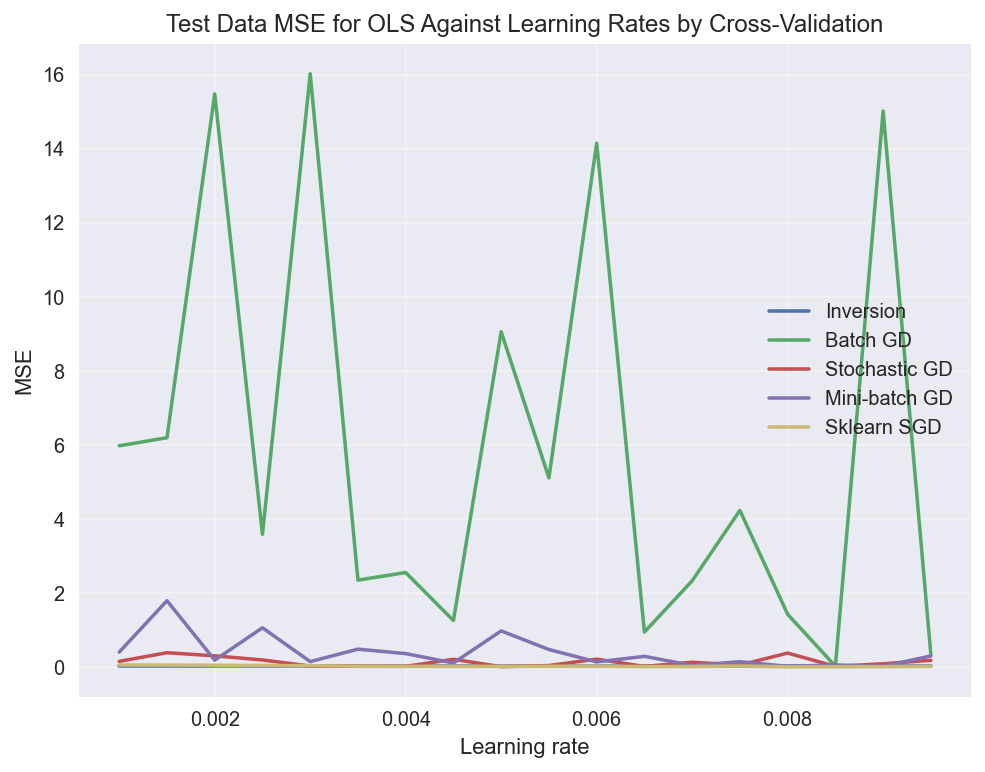

In [173]:
from sklearn.model_selection import KFold

# PLOT OF OLS REGRESSION AS FUNCTION OF THE CHOSEN LEARNING RATES

### Create data
np.random.seed(40)

n = 20          # n x n number of data points
sigma2 = 0.01   # irreducible error
sigma = np.sqrt(sigma2)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for Cross-validation
max_lr = 0.01
step = 0.0005
lrs = np.arange(0.001, max_lr, step, dtype=float)

# Initialize a KFold instance
k = 5
KFold = KFold(n_splits=5, shuffle=False)

# Perform the cross-validation to estimate MSE
scores_KFold_inv = np.zeros((len(lrs), k))
scores_KFold_bgd = np.zeros((len(lrs), k))
scores_KFold_sgd = np.zeros((len(lrs), k))
scores_KFold_mbgd = np.zeros((len(lrs), k))
scores_KFold_sgd_sklearn = np.zeros((len(lrs), k))

deg = 5
# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

for i, lr in enumerate(lrs):

    j = 0
    for train_inds, test_inds in KFold.split(x):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]
        
        # Scale the data, i.e, subtract the mean and divide by std (based on the training set)
        X_train_scaled, X_test_scaled = normalize_data(X_train, X_test, with_intercept=False)
        z_train_scaled, z_test_scaled = normalize_target(z_train, z_test)
        
        inv_reg = GDRegressor(eta=lr, fit_intercept=True)
        bgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        sgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        mbgd_reg = GDRegressor(eta=lr, n_epochs=75, fit_intercept=True)
        sgdreg_sk = SGDRegressor(max_iter=1000, penalty=None, eta0=lr, alpha=0, 
                                 tol=1e-5, fit_intercept=True) # sklearn
        
        inv_reg.fit(X_train_scaled, z_train_scaled, weights="normal", method="Inv")
        bgd_reg.fit(X_train_scaled, z_train_scaled, weights="normal", method="BGD")
        sgd_reg.fit(X_train_scaled, z_train_scaled, weights="normal", method="SGD")
        mbgd_reg.fit(X_train_scaled, z_train_scaled, weights="normal", method="MBGD")
        
        sgdreg_sk.fit(X_train_scaled, z_train_scaled) #sklearn
        z_pred_sk = sgdreg_sk.predict(X_test_scaled)
        
        scores_KFold_inv[i, j] = inv_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_bgd[i, j] = bgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd[i, j] = sgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_mbgd[i, j] = mbgd_reg.mse(X_test_scaled, z_test_scaled)
        scores_KFold_sgd_sklearn[i, j] = mean_squared_error(z_test_scaled, z_pred_sk)
        
    j += 1
    

mse_KFold_inv = np.mean(scores_KFold_inv, axis=1)
mse_KFold_bgd = np.mean(scores_KFold_bgd, axis=1)
mse_KFold_sgd = np.mean(scores_KFold_sgd, axis=1)
mse_KFold_mbgd = np.mean(scores_KFold_mbgd, axis=1)
mse_KFold_sgd_sklearn = np.mean(scores_KFold_sgd_sklearn, axis=1)

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
plt.grid(alpha=0.3)
plt.plot(lrs, mse_KFold_inv, label='Inversion')
plt.plot(lrs, mse_KFold_bgd, label='Batch GD')
plt.plot(lrs, mse_KFold_sgd, label='Stochastic GD')
plt.plot(lrs, mse_KFold_mbgd, label='Mini-batch GD')
plt.plot(lrs, mse_KFold_sgd_sklearn, label='Sklearn SGD')
plt.legend()
plt.xlabel("Learning rate")
plt.ylabel("MSE")
#plt.yscale('log')
plt.title('Test Data MSE for OLS Against Learning Rates by Cross-Validation')
plt.show()
fig.savefig(fig_path("OLS_MSE_lrs_momentum_epochs_250.pdf"), dpi=300)